## Imports

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import random

# Configurations
N_DAYS = 5
N_MODALITIES = 1
IMG_SIZE = (64, 64)
BASE_DIR = "/kaggle/input/hab-200/dataset_200"
MAX_SAMPLES_PER_CLASS = {'0':90, '1':200}

## Data Loading

In [ ]:
def load_data(base_dir, samples_per_class):
    X, y = [], []
    for label, max_per_class in samples_per_class.items():
        label_dir = os.path.join(base_dir, label)
        sample_folders = sorted(os.listdir(label_dir))
        random.shuffle(sample_folders) 
        count = 0
        
        for folder in sample_folders:
            if count >= max_per_class:
                break
            try:
                day_images = []
                for day in range(1, N_DAYS + 1):
                    img_path = os.path.join(label_dir, folder, "1", f"{day:02}.png")
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("Missing image")
                    img = cv2.resize(img, IMG_SIZE)
                    img = img.astype("float32") / 255.0
                    day_images.append(img)
                sample = np.stack(day_images, axis=0)
                X.append(sample)
                y.append(int(label))
                count += 1
            except:
                continue
    return np.array(X), np.array(y)

X, y = load_data(BASE_DIR, MAX_SAMPLES_PER_CLASS)
print("Loaded:", X.shape, y.shape)

Loaded: (290, 5, 64, 64, 3) (290,)


## Data Preprocessing

In [4]:
X_flat = X.reshape(len(X), -1)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, stratify=y, random_state=42, shuffle = True)

In [6]:
n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
scale_pos_weight = n_neg / n_pos
print(f"Using scale_pos_weight={scale_pos_weight:.2f}")

Using scale_pos_weight=0.45


## Model Training

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.90      0.88      0.89        40

    accuracy                           0.84        58
   macro avg       0.82      0.83      0.82        58
weighted avg       0.85      0.84      0.85        58



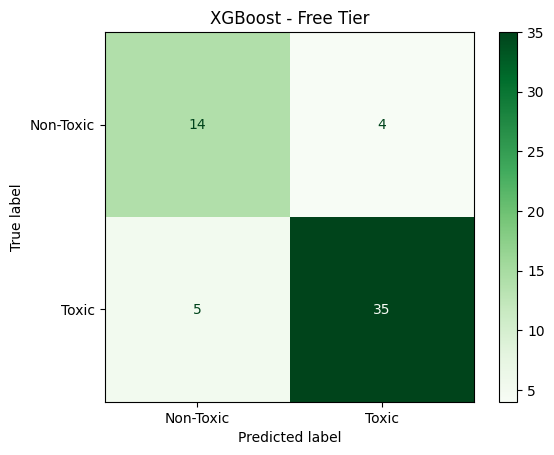

In [7]:
xgb = XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Non-Toxic", "Toxic"], cmap="Greens")
plt.title("XGBoost - Free Tier")
plt.show()

## Loading Test Data

In [8]:
test_X, test_y = load_data('/kaggle/input/test-hab-200/Test_HAB_200', {'0':150, '1':150})
print("Loaded:", test_X.shape, test_y.shape)

Loaded: (300, 5, 64, 64, 3) (300,)


In [9]:
test_X = test_X.reshape(len(test_X), -1)

In [10]:
p = np.random.permutation(len(test_X))
X_test_shuffled = test_X[p]
y_test_shuffled = test_y[p]

## Testing model on unseen data

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       150
           1       0.68      0.71      0.69       150

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



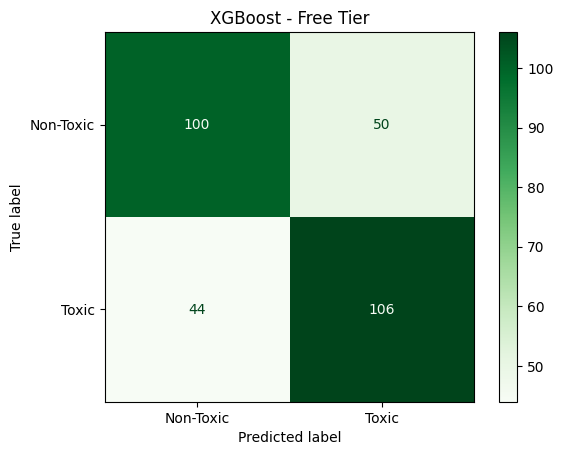

In [11]:
preds = xgb.predict(X_test_shuffled)

print(classification_report(y_test_shuffled, preds))
ConfusionMatrixDisplay.from_predictions(y_test_shuffled, preds, display_labels=["Non-Toxic", "Toxic"], cmap="Greens")
plt.title("XGBoost - Free Tier")
plt.show()

## Predictions for unseen single datacube

In [20]:
def load_datacube(folder_path):
    day_images = []
    for day in range(1, N_DAYS + 1):
        img_path = os.path.join(folder_path, "1", f"{day:02}.png")
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("Missing image")
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype("float32") / 255.0
        day_images.append(img)
    sample = np.stack(day_images, axis=0)
    return np.array(sample).flatten()

In [21]:
x = load_datacube('/kaggle/input/test-hab-200/Test_HAB_200/0/habnet_datacube_20160404_26.7614_-82.0611_0')
xgb.predict([x])[0], xgb.predict_proba([x])

(0, array([[0.6606598 , 0.33934024]], dtype=float32))

In [22]:
x = load_datacube('/kaggle/input/test-hab-200/Test_HAB_200/0/habnet_datacube_20160321_27.311_-82.5772_0')
xgb.predict([x])[0], xgb.predict_proba([x])

(0, array([[0.5018156 , 0.49818438]], dtype=float32))

In [23]:
x = load_datacube('/kaggle/input/test-hab-200/Test_HAB_200/1/habnet_datacube_20161003_27.5298_-82.704_250667')
xgb.predict([x])[0], xgb.predict_proba([x])

(1, array([[0.058936, 0.941064]], dtype=float32))

In [24]:
x = load_datacube('/kaggle/input/test-hab-200/Test_HAB_200/1/habnet_datacube_20161007_27.3316_-82.5779_516000')
xgb.predict([x])[0], xgb.predict_proba([x])

(1, array([[0.11348504, 0.88651496]], dtype=float32))

## Saving Model

In [25]:
import pickle
with open ('free_tier_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)